# Домашняя работа.
## Обработка изображений и перевод в другое цветовое пространство.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import imageio

#### Загрузка изображения

In [0]:
img = imageio.imread('/content/drive/My Drive/Vision/1Lesson/Beauty.jpg')

In [3]:
print(img.shape)

(517, 750, 3)


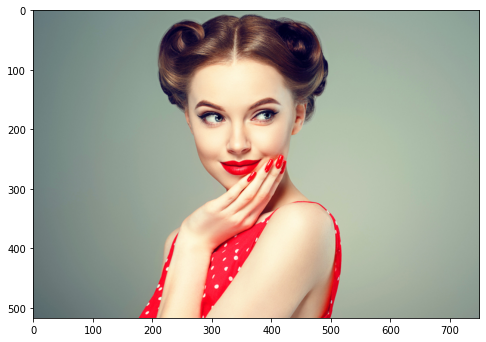

In [4]:
plt.figure(figsize=(8, 8))
plt.imshow(img);

#### попытаемся сделать эффект чб фото но с сохранением красных обьектов на изображении

In [0]:
from skimage.color import rgb2hsv, hsv2rgb, rgb2lab, lab2rgb

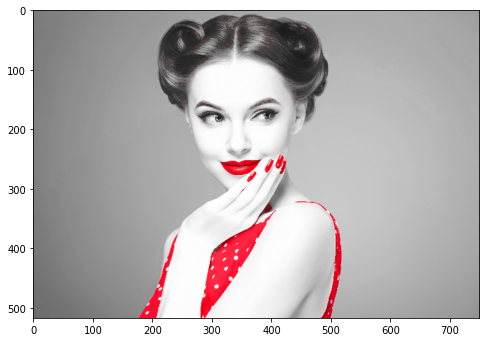

In [6]:
img_hsv = rgb2hsv(img)
x,y = np.where((img_hsv[:,:,0] < 0.97) )
img_hsv[x,y,1] = 0
plt.figure(figsize=(8, 8))
plt.imshow(hsv2rgb(img_hsv));

Результат не очень , плохое чб качество и остался красный цвет на шее под рукой. попробуем через ргб

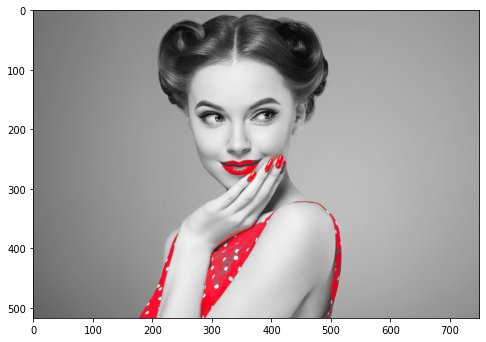

In [7]:
img_rgb = np.copy(img)
x,y = np.where((img_rgb[:,:,0] >215) & (img_rgb[:,:,1] <100)& (img_rgb[:,:,2] <70))

img_grays = np.mean(img, axis=2)
img_grays = np.stack((img_grays,img_grays,img_grays),axis =2).astype(np.int)
img_grays[x,y,:] = img_rgb[x,y,:]

plt.figure(figsize=(8, 8))
plt.imshow(img_grays);

Тоже не очень . разделение на 3 цветовых канала дает шум при точной выборке цвета. Попробуем лаб

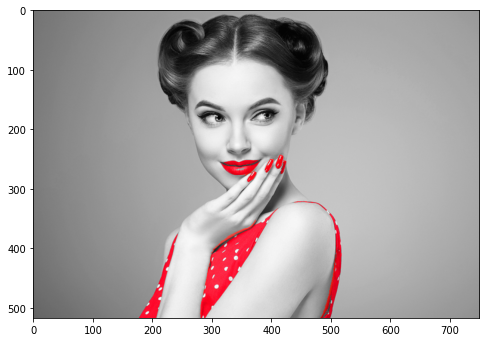

In [8]:
img_lab = rgb2lab(img)
x,y = np.where((img_lab[:,:,1] <60))
img_lab[x,y,1] = 0
img_lab[x,y,2] = 0
plt.figure(figsize=(8, 8))
plt.imshow(lab2rgb(img_lab));

лучше но плохо : губы , засвет на руке , платье сзади. попробуем комбинацию
ХСВ + ЛАБ 

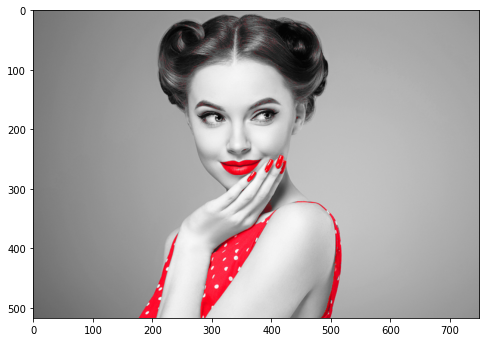

In [9]:
img_lab = rgb2lab(img)
x,y = np.where((img_hsv[:,:,0] < 0.97) & (img_lab[:,:,1] >-20) )
img_lab[x,y,1] = 0
img_lab[x,y,2] = 0
plt.figure(figsize=(8, 8))
plt.imshow(lab2rgb(img_lab));

То что надо , но красный на шее все равно остался .

In [0]:
img = lab2rgb(img_lab)

## Оконная обработка изображения (фильтрация)

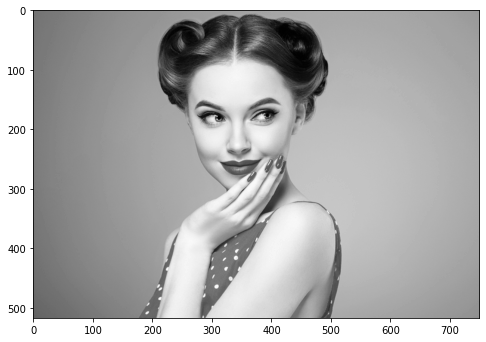

In [11]:
img = np.mean(img, axis=2)
plt.figure(figsize=(8, 8))
plt.imshow(img,cmap = 'gray');

In [0]:
import scipy.signal

In [0]:
win_size = (11, 11)
sigma = 3

win_box = np.ones(win_size, dtype=np.float32)
win_box = win_box / np.sum(win_box)


win_gauss = np.zeros(win_size, dtype=np.float32)
for i in range(win_size[0]):
        for j in range(win_size[1]):
            win_gauss[i,j] = np.exp(-(i-win_size[0]//2)**2 / sigma**2 / 2 
                            -(j-win_size[1]//2)**2 / sigma**2 / 2)
win_gauss = win_gauss / np.sum(win_gauss)


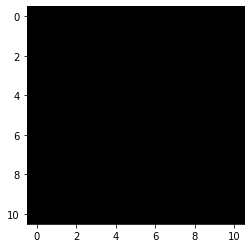

In [14]:
plt.imshow(win_box, cmap='gray');

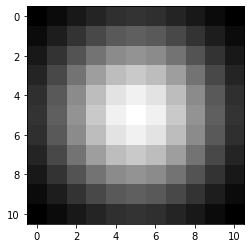

In [15]:
plt.imshow(win_gauss, cmap='gray');

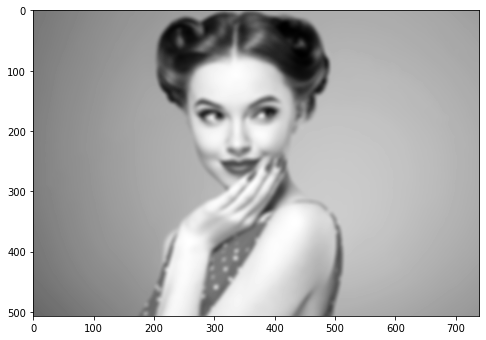

In [16]:
img_gauss =scipy.signal.correlate2d(img, win_gauss, mode='valid')
plt.figure(figsize=(8, 8))
plt.imshow(img_gauss,cmap = 'gray');

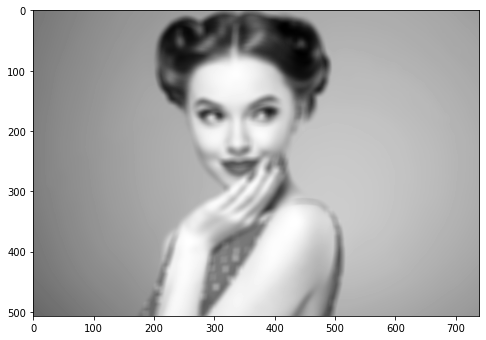

In [17]:
img_box =scipy.signal.correlate2d(img, win_box, mode='valid')
plt.figure(figsize=(8, 8))
plt.imshow(img_box,cmap = 'gray');

разница между боксом и гаусом :

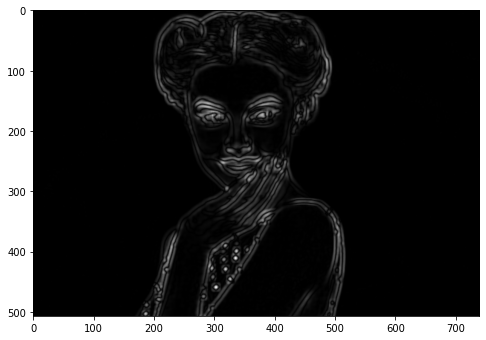

In [18]:
plt.figure(figsize=(8, 8))
plt.imshow(np.absolute(img_box-img_gauss),cmap = 'gray');

пробуем как в уроке выделить контура через свертку

In [0]:
def mult_window(size = 5, ver = True):
    ar = []
    for i in range(size):
        ar.append(np.linspace(-100,100,size))
    ar = np.array(ar)
    ar = ar if ver else ar.T
    plt.imshow(ar,cmap = 'gray');
    return ar 


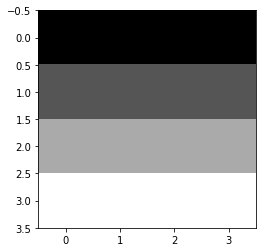

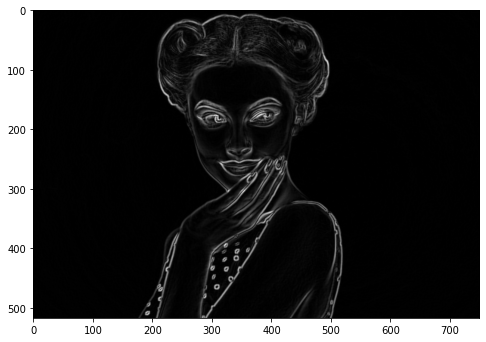

In [20]:
horizontal_conv = scipy.signal.convolve2d(img, mult_window(size = 4, ver = True), boundary='symm', mode='same')
horizontal_conv =np.absolute(horizontal_conv)

vertical_conv = scipy.signal.convolve2d(img, mult_window(size = 4, ver = False), boundary='symm', mode='same')
vertical_conv =np.absolute(vertical_conv)

combinet_conv = np.absolute(horizontal_conv + vertical_conv)

plt.figure(figsize=(8, 8))
plt.imshow(combinet_conv,cmap = 'gray');

ядро свертки через комплексные числа (как в документации сайпая)

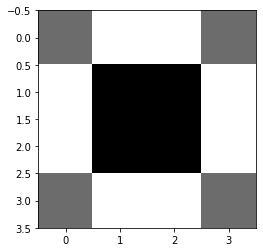

In [21]:
kross = np.array([[ -3-3j, 0-10j, 0-10j, +3 -3j],
                  [-10+0j, 0+ 0j, 0+ 0j, +10 +0j],
                  [-10+0j, 0+ 0j, 0+ 0j, +10 +0j],
                  [ -3+3j, 0+10j, 0+10j, +3 +3j]])
plt.imshow(np.absolute(kross),cmap = 'gray');

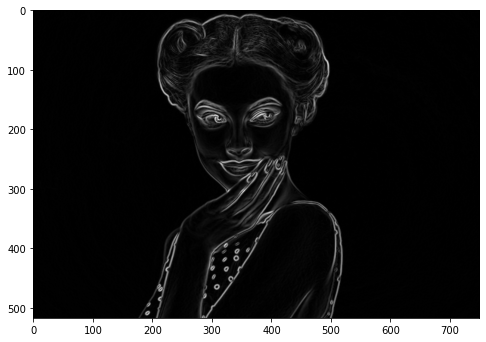

In [22]:
complex_convolut = scipy.signal.convolve2d(img, kross, boundary='symm', mode='same')
complex_convolut = np.absolute(complex_convolut)
plt.figure(figsize=(8, 8))
plt.imshow(complex_convolut, cmap = 'gray');


и сравним их 

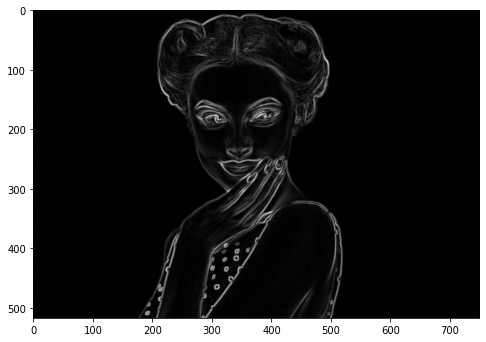

In [23]:
plt.figure(figsize=(8, 8))
plt.imshow(np.absolute(complex_convolut-combinet_conv), cmap = 'gray');